<a href="https://colab.research.google.com/github/ChrisFJardine/Masterclass/blob/main/CJardineAssignment3__Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import re
import time
import datetime
import os
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn
import statistics as stat
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()


%matplotlib inline 
from datetime import datetime, timedelta

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [173]:
#Load the output from the crawler
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/ExtractedNews.csv', header = None)

In [174]:
#tidy the dataframe
docs = []
for x in range(news.shape[1]):
  for y in range(news.shape[0]):
    if isinstance(news[x][y], str):
      docs.append(news[x][y])
df = pd.DataFrame(docs)

In [150]:
#tokenise a doc into sentences then return the average sentiment score for all sentences 
def get_avg_sent(doc):
  x = []
  for sent in  nltk.sent_tokenize(doc):
    x.append(sid.polarity_scores(sent)['compound'])
  return(stat.mean(x))
  

In [177]:
#Clean the corpus.
df = pd.DataFrame(docs)
df['date'] = df[0].apply(lambda x: datetime.strptime(re.search(r'\d{4}-\d{2}-\d{2}', str(x)).group(),'%Y-%m-%d').date())
df['text'] = df[0].str.replace('[^\w\s]', '')       #Strip punctuation
df['text'] = df['text'].str.replace('\d+','')       #Strip numbers
df['text'] = df['text'].str.lstrip()                #Strip leading space
df['text'] = df['text'].str.lower()                 #to lower case
df.sort_values(by='date', inplace=True)


In [178]:
#Get compount sentiment of each document    
df['sentiment'] = df.apply(lambda x: sid.polarity_scores(x.text), axis=1)
df['doc_sentiment']  = df['sentiment'].apply(lambda score_dict: score_dict['compound'])


In [181]:
#store text for .
df['sentence_text'] = df[0]
df['sentence_text'] = df['sentence_text'].str[16:]
df['tokenised_avg_sentiment'] = df.apply(lambda x: get_avg_sent(x.sentence_text), axis = 1)


In [ ]:
df = df.drop(df.columns[[0]], 1)

In [203]:
df_grouped = df.groupby('date').mean()

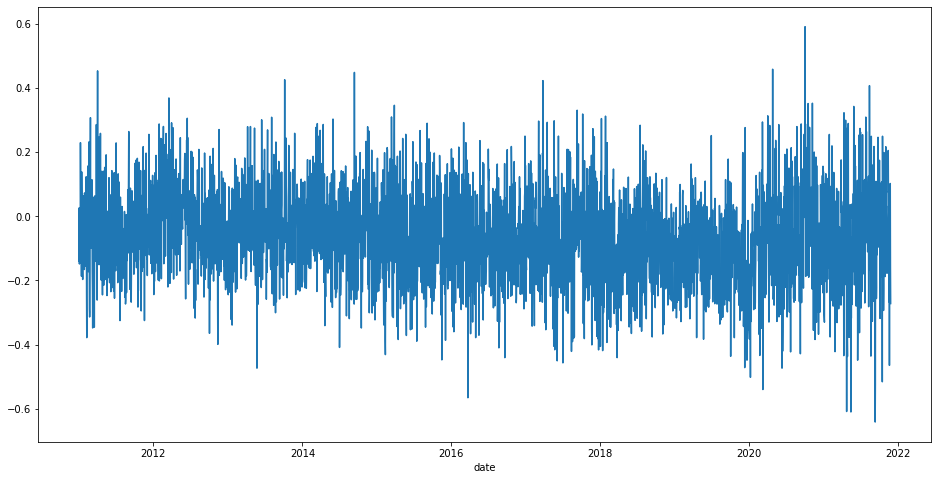

In [193]:
df_grouped['doc_sentiment'].plot(figsize = (16,8))

In [204]:
df_grouped['rolling_doc_sentiment'] = df_grouped['doc_sentiment'].rolling(window=30).mean() 
df_grouped['rolling_tokenised_avg_sentiment'] = df_grouped['tokenised_avg_sentiment'].rolling(window=30).mean()

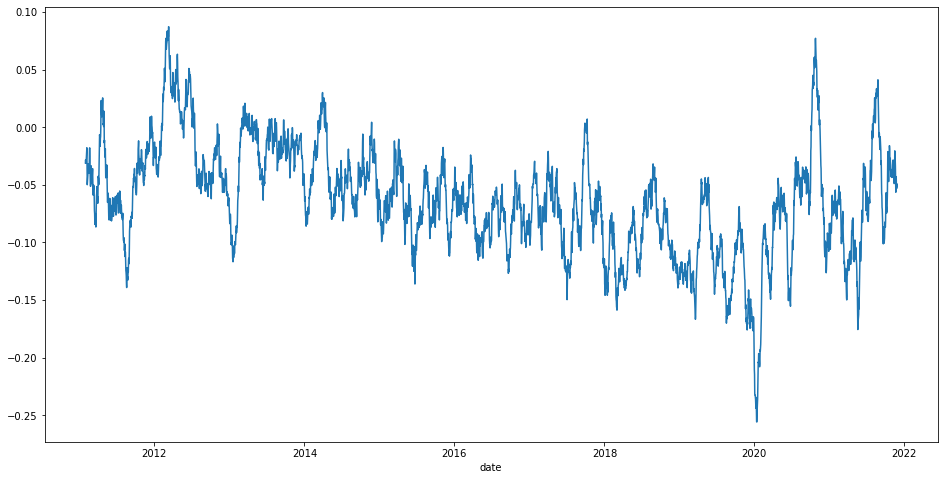

In [205]:
df_grouped['rolling_doc_sentiment'].plot(figsize = (16,8))

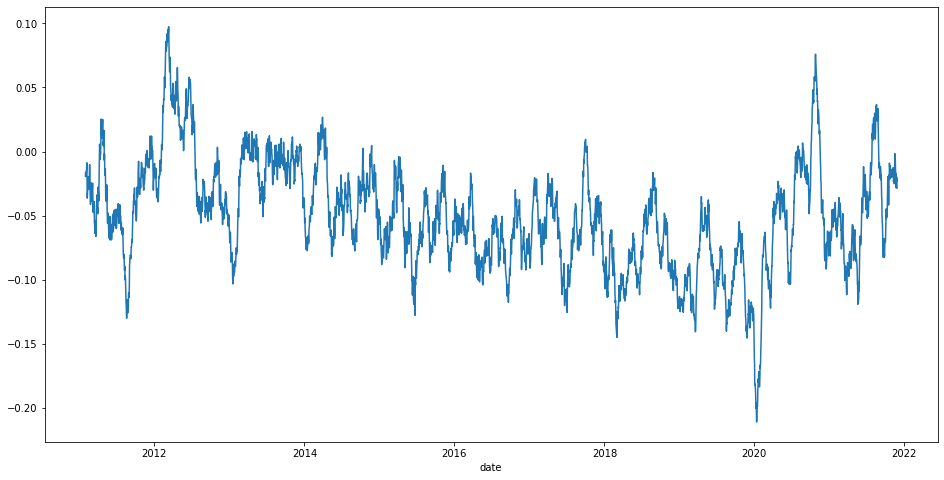

In [207]:
df_grouped['rolling_tokenised_avg_sentiment'].plot(figsize = (16,8))

In [221]:
stop = stopwords.words('english')
additional_stopwords = ['australia','australian','grandstand','grandstands','australias'] 
for word in additional_stopwords:
  stop.append(word)
df['words'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))


In [218]:
df2012 = df[( df['date'] > pd.Timestamp(2012,1,1))  &  (df['date'] < pd.Timestamp(2013,1,1)) ] 
listwords2012 = ' '.join([x for x in df2012.words]).split()

df2019 = df[( df['date'] > pd.Timestamp(2019,1,1))  &  (df['date'] < pd.Timestamp(2020,1,1)) ] 
listwords2019 = ' '.join([x for x in df2019.words]).split()


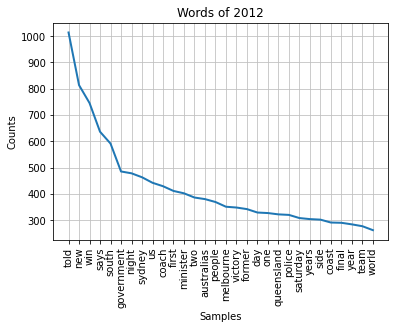

In [220]:
fdist = FreqDist(listwords2012)
fdist.plot(30, cumulative = False, title = 'Words of 2012' )

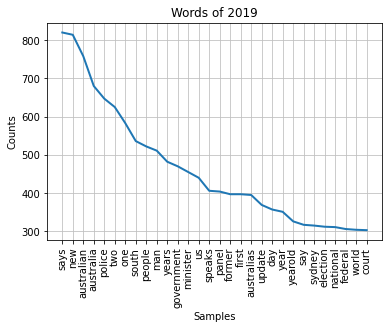

In [ ]:
fdist = FreqDist(listwords2019)
fdist.plot(30, cumulative = False, title = 'Words of 2019')

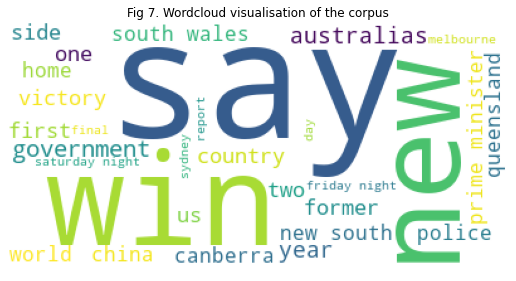

In [223]:

text = " ".join(desc for desc in listwords2012)
wordcloud = WordCloud(max_words = 30, background_color="white").generate(text)
plt.figure(figsize = [9,9])
plt.imshow(wordcloud, interpolation='antialiased')
plt.title('Fig 7. Wordcloud visualisation of the corpus')
plt.axis("off")
plt.show()

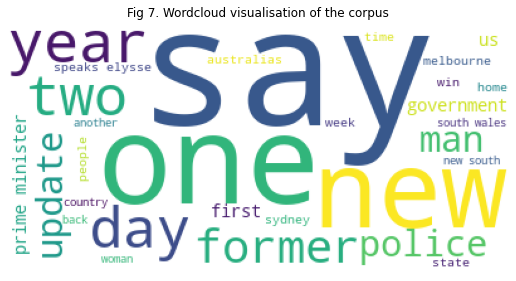

In [225]:
text = " ".join(desc for desc in listwords2019)
wordcloud = WordCloud(max_words = 30, background_color="white").generate(text)
plt.figure(figsize = [9,9])
plt.imshow(wordcloud, interpolation='antialiased')
plt.title('Fig 7. Wordcloud visualisation of the corpus')
plt.axis("off")
plt.show()

In [226]:
cricket = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/AusCricketResults.csv')
cricket = cricket.dropna()
cricket[['days','year']] = cricket['Match Date'].str.split(',', expand = True)
cricket[['test_start', 'test_end']] = cricket['days'].str.split('-', expand = True)
cricket['test_date'] = cricket['test_start']  + cricket['year']
cricket['test_date'] = pd.to_datetime(cricket['test_date'])
cricket.drop(['days', 'year', 'test_start','test_end'], axis=1, inplace=True)
cricket['score'] = 0
cricket.loc[cricket['Winner'] == 'Australia', 'score' ] = 1  
cricket['momentum'] = cricket['score'].rolling(window=10).mean()


In [256]:
crick_trend =  cricket[['test_date','momentum']].fillna(0)
crick_trend['test_date'] = pd.to_datetime(crick_trend['test_date'])
#crick_trend.plot(figsize = (16,8))
crick_trend = crick_trend.set_index('test_date')
#df_grouped.join(crick_trend)


In [257]:
data = df_grouped.join(crick_trend)
#data = data.drop(['compound'], axis = 1)

,doc_sentiment,tokenised_avg_sentiment,rolling_doc_sentiment,rolling_tokenised_avg_sentiment,momentum
2011-01-01,-0.139552,-0.121928,NaN,NaN,NaN
2011-01-02,0.026228,0.028448,NaN,NaN,NaN
2011-01-03,-0.148567,-0.119029,NaN,NaN,0.4
2011-01-04,-0.086444,-0.069268,NaN,NaN,NaN
2011-01-05,-0.146180,-0.115440,NaN,NaN,NaN
...,...,...,...,...,...
2021-11-22,-0.026040,0.015567,-0.042835,-0.017294,NaN
2021-11-23,-0.077362,-0.001219,-0.052026,-0.023700,NaN
2021-11-24,0.102114,0.125296,-0.049135,-0.019941,NaN
2021-11-25,-0.159054,-0.111904,-0.048935,-0.022430,NaN


In [255]:
d#Manually add the momentum for the first record and fill momentum for dates with no cricket on.
data.iloc[0]['momentum'] = 0.4
data['momentum'] = data['momentum'].fillna(method='ffill')
data = data.fillna(0)


In [258]:
#Normalise the sentiment and the cricket momentum
cols_to_norm = ['rolling_tokenised_avg_sentiment','momentum']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

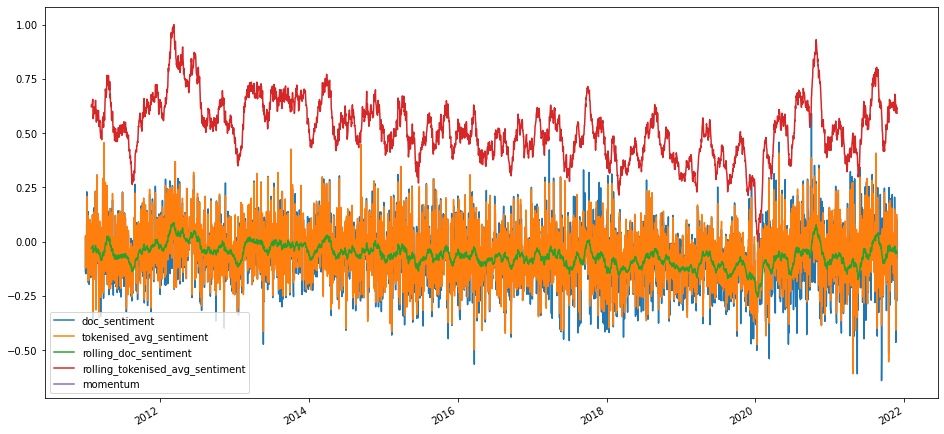

In [259]:
#What the hell does this even look like?!
data.plot(figsize = (16,8))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


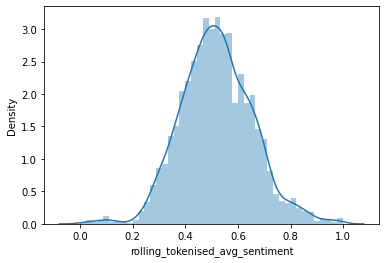

In [235]:
#Try a regression model
seaborn.distplot(data['rolling_tokenised_avg_sentiment'])

In [239]:
#Try a regression model
data = data.fillna(0)
X = data['momentum'].values.reshape(-1,1)
y = data['rolling_tokenised_avg_sentiment'].values.reshape(-1,1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [241]:
regressor = LinearRegression()  
regressor.fit(train_X, train_y)
y_pred = regressor.predict(test_X)
results = pd.DataFrame({'Actual': test_y.flatten(), 'Predicted': y_pred.flatten()})
results

,Actual,Predicted
0,0.287556,0.515678
1,0.552868,0.515678
2,0.363546,0.515678
3,0.511882,0.515678
4,0.548535,0.515678
...,...,...
791,0.451479,0.515678
792,0.460884,0.515678
793,0.522957,0.515678
794,0.569071,0.515678


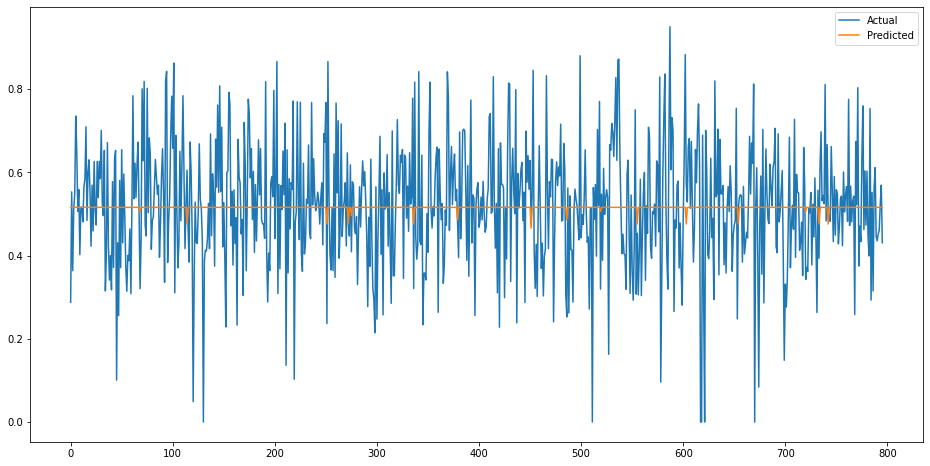

In [249]:

results.plot(figsize = (16,8))

In [243]:
data['momentum'].corr(data['rolling_tokenised_avg_sentiment'])
#Pearson correlation close to 0. Not correlated.

-0.0412238752182645

In [244]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))


Mean Absolute Error: 0.11319084737237449
Mean Squared Error: 0.021806788837855362
Root Mean Squared Error: 0.14767121871866354


In [ ]:
#So what were the happy times?
happy_times = df[df['compound'] > .98]
sad_times = df[df['compound'] < -.9925 ]

In [ ]:
sad_times.size

12

In [ ]:
pd.set_option('display.max_colwidth', None)

for text in happy_times['text']:
  print(text.lstrip())

shes the stoic enduring face of the struggle against military rule in her poor and brutally oppressed country persistently pushing against the heavy hand of the junta her dignified perseverance  even during years of house arrest  has made aung san suu kyi a towering figure of inspiration at home and abroad but at  is the nobel peace prize winner and democracy icon still the best hope for freedom in burma after a risky path to her front door we find aung san suu kyi expansive candid and resolute but time is passing and genuine change seems as far away as ever
bryce courtenay was one of australias best loved authors but it was a character he created that was possibly his best seller the yowie an australian chocolate for kids was also cadburys top selling product in the nineties but it was pulled from the shelves a decade ago after a copyright dispute now the yowie is being remoulded it is seeing sweet success in the united states where its biggest rival the kinder surprise is locked out


In [ ]:
for text in sad_times['text']:
  print(text.lstrip())

burma has pardoned hundreds of prisoners under an amnesty criticised by prodemocracy activists as a cynical ploy to curry favour before a landmark visit by us president barack obama officials said  prisoners would walk free but most or all of them appeared to be ordinary criminals rights groups said they were not aware of the release of any of the scores of dissidents still in jail the assistance association for political prisoners aapp a thailandbased campaign group described the pardon as the worst amnesty to date burma has already freed hundreds of political prisoners incarcerated by the former junta as part of reforms that have led to a dramatic thaw in relations between the onetime pariah nation and the west campaigners including new yorkbased human rights watch cast doubt on the motivation for the latest amnesty it seems there is a new game in burma which is the political prisoners game said hrw deputy asia director phil robertson calling the release cynical and lacking in transp

In [ ]:
happy_times

,date,text,sentiment,compound
93087,2011-07-19,shes the stoic enduring face of the struggle against military rule in her poor and brutally oppressed country persistently pushing against the heavy hand of the junta her dignified perseverance even during years of house arrest has made aung san suu kyi a towering figure of inspiration at home and abroad but at is the nobel peace prize winner and democracy icon still the best hope for freedom in burma after a risky path to her front door we find aung san suu kyi expansive candid and resolute but time is passing and genuine change seems as far away as ever,"{'neg': 0.091, 'neu': 0.624, 'pos': 0.284, 'compound': 0.9844}",0.9844
93906,2014-08-13,bryce courtenay was one of australias best loved authors but it was a character he created that was possibly his best seller the yowie an australian chocolate for kids was also cadburys top selling product in the nineties but it was pulled from the shelves a decade ago after a copyright dispute now the yowie is being remoulded it is seeing sweet success in the united states where its biggest rival the kinder surprise is locked out,"{'neg': 0.035, 'neu': 0.619, 'pos': 0.346, 'compound': 0.9858}",0.9858
60584,2017-01-24,david warner may have won backtoback alan border medals but meg lanning has gone one better last night she won her third belinda clark award the highest honour for a female cricketer and some are now saying she may just be the greatest of all time,"{'neg': 0.0, 'neu': 0.592, 'pos': 0.408, 'compound': 0.9832}",0.9832


In [ ]:
sad_times

,date,text,sentiment,compound
15245,2012-11-15,burma has pardoned hundreds of prisoners under an amnesty criticised by prodemocracy activists as a cynical ploy to curry favour before a landmark visit by us president barack obama officials said prisoners would walk free but most or all of them appeared to be ordinary criminals rights groups said they were not aware of the release of any of the scores of dissidents still in jail the assistance association for political prisoners aapp a thailandbased campaign group described the pardon as the worst amnesty to date burma has already freed hundreds of political prisoners incarcerated by the former junta as part of reforms that have led to a dramatic thaw in relations between the onetime pariah nation and the west campaigners including new yorkbased human rights watch cast doubt on the motivation for the latest amnesty it seems there is a new game in burma which is the political prisoners game said hrw deputy asia director phil robertson calling the release cynical and lacking in transparency obama will on monday become the first sitting us president to visit burma where he will meet former general president thein sein and opposition leader aung san suu kyi the countrys most famous former political prisoner a spokesman for suu kyis national league for democracy nld also questioned the timing of the latest mass pardon it is strange that they released prisoners just before obamas visit ohn kyaing told afp they should have done it before and showed their genuine will to give the amnesty he said adding that it was unclear if any nld members were among those being freed other prominent prodemocracy figures also called for an immediate release of all prisoners of conscience kyaw min yu a leader of generation named for a student uprising brutally suppressed by the army in called a full amnesty critical to national reconciliation after five decades of military rule the release of prisoners should not be related to obamas trip its just something the government should do as quickly as possible he said the last major amnesty in september saw dozens of dissidents freed just before a historic visit to the united nations in new york by thein sein but many political prisoners were left behind bars to the dismay of democracy campaigners estimates of their number vary but the aapp put the figure at in a list posted on its website on october the group said it had not heard of any dissidents freed on thursday as recently as about a year ago rights groups accused burma of wrongfully imprisoning some political opponents dissidents and journalists the visit by obama fresh from his reelection victory has been lauded by burma as a sign of confidence in the reforms introduced under a nominally civilian government which replaced the junta in march it also comes as deadly communal violence between buddhists and muslims in the countrys impoverished west casts a shadow over the political changes clashes in rakhine state have claimed lives since june and forced more than people mainly rohingya muslims into makeshift camps,"{'neg': 0.155, 'neu': 0.768, 'pos': 0.077, 'compound': -0.9946}",-0.9946
64149,2017-05-31,in this update at least people have been killed and more than injured after a car bomb exploded near foreign embassies in the afghan capital kabul the cousin of a melbourne schoolgirl killed in a bomb blast in iraq says the spread of terrorism is devastating families around the world and the cousin of a melbourne schoolgirl killed in a bomb blast in iraq says the spread of terrorism is devastating families around the world,"{'neg': 0.427, 'neu': 0.573, 'pos': 0.0, 'compound': -0.9931}",-0.9931
67785,2017-05-31,in this update at least people have been killed and more than injured after a car bomb exploded near foreign embassies in the afghan capital kabul the cousin of a melbourne schoolgirl killed in a bomb blast in iraq says the spread of terrorism is devastating families around the world and the cousin 